# Investigation of the feasibility of urban building height analysis using remote sensing

## Datasets

Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A

Plateau by MILT dataset

### Library Imports

In [96]:
import ee
import geemap
from osgeo import gdal
import matplotlib.pyplot as plt
import math
import gdown
import cv2
import numpy as np
from datetime import datetime
import requests
import time
import json

import pandas as pd
import geopandas
import subprocess
import os
from shapely.geometry import Polygon, Point, shape
from scipy.ndimage import rotate


import rasterio as rio
import pyproj

In [2]:
# Authenticate if required
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [3]:
# Import submodule
import dl_sentinel as ds


In [4]:
def getCoordinates(geo_transform, col_index, row_index):
    """
    Returns the coordinates given the pixel position in the array\n
    Designed for EPSG:3857, gets wonky with other projections\n
    """
    # print(geo_transform)
    px = geo_transform[0]
    py = geo_transform[3]
    rx = geo_transform[1]
    ry = geo_transform[5]
    x = px + col_index*rx
    y = py + row_index*ry # ry is negative
    return x, y

def getPixel(geo_transform, x,  y):
    """
    Returns the indices of the pixels given the coordinates in the array\n
    Designed for EPSG:3857, gets wonky with other projections\n
    """
    # print(geo_transform)
    px = geo_transform[0]
    py = geo_transform[3]
    rx = geo_transform[1]
    ry = geo_transform[5]
    col_index = (x - px) / rx
    row_index = (y - py) / ry
    # Compared to int(), using math.ceil() keeps the deviation per iteration asymptopic
    # For other datasets/projects would be good to re-evaluate
    return math.ceil(row_index), math.ceil(col_index)

def convertCoords(x, y, src, target):
    """
    Converts the coordinates from the source projection to the target projection\n
    # Parameters \n
    x: Usually the latitude or the x value\n
    y: Usually the longitude or the y value\n
    src: The source projection eg. "epsg:3857"\n
    target: The target projection eg. "epsg:4326"\n
    """
    transformer = pyproj.Transformer.from_crs(src, target)
    return transformer.transform(x, y)


In [5]:
def getBounds(data):
    """
    Gets the bounds of the gdal dataset object\n
    # Parameters:\n
    data: gdal.Open() object \n
    # Returns:\n
    min_x, min_y, max_x, max_y \n
    """
    ulx, xres, xskew, uly, yskew, yres  = data.GetGeoTransform()
    lrx = ulx + (data.RasterXSize * xres)
    lry = uly + (data.RasterYSize * yres)
    print("Upper Left Corner:", ulx, uly)
    print("Lower Right Corner:", lrx, lry)
    print("Width:", abs(lrx - ulx))
    print("Height:", abs(uly- lry))
    print("Area:", abs(lrx - ulx) * abs(uly- lry))
    print("Pixel Width:", abs(data.GetGeoTransform()[1]))
    min_x = min(lrx, ulx)
    min_y = min(lry, uly)
    max_x = max(lrx, ulx)
    max_y = max(lry, uly)
    return min_x, min_y, max_x, max_y

In [6]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [7]:
# Deprecated

def calcUMP(arr, percentile= 98, ignore_zero= True, resolution= 0.1):
    """
    Given a 2D numpy array, where the elements represent the height, return the Urban Morphological Parameters in a dictionary\n
    All values are in metres\n
    # Parameters:\n
    arr: 2D numpy array\n
    percentile: The percentile of height to return\n
    ignore_zero: Exclude 0 values (non-buildings) from calculation of UMP\n
    resolution: The resolution of the array in metres\n

    # Returns\n
    AverageHeight\n
    MaximumHeight\n
    MinimumHeight\n
    PercentileHeight\n
    Percentile\n
    StandardDeviation\n
    PlanarArea\n
    FrontalArea\n
    TotalArea\n

    """
    arr_copy = arr.copy()
    if ignore_zero:
        arr_copy[arr_copy == 0] = np.nan
    
    r = {}

    # Average Height
    r["AverageHeight"] = np.nanmean(arr_copy)

    # Maximum Height
    r["MaximumHeight"] = np.nanmax(arr_copy)

    # Minimum Height
    r["MinimumHeight"] = np.nanmin(arr_copy)

    # Percentile Height
    r["PercentileHeight"] = np.nanpercentile(arr_copy, percentile)

    # Percentile for reference
    r["Percentile"] = percentile

    # Standard Deviation
    r["StandardDeviation"] = np.nanstd(arr_copy)

    # Planar Area
    r["PlanarArea"] = np.sum(arr_copy > 0) * resolution**2
    
    # Total Area
    r["TotalArea"] = arr_copy.size * resolution**2

    # # Frontal Area
    # # Algorithm is a little slow
    # tic = time.time()
    # frontal_area = 0
    # for row in range(1, arr.shape[0]): # skips the first row as it is extremely unlikely that a building ends right there
    #     for col in range(arr.shape[1]):
    #         val = arr[row, col]
    #         if val > 0 and arr[row-1, col] == 0:
    #             frontal_area += val*resolution
    # r["FrontalArea"] = frontal_area
    # print("Frontal Area 1:", time.time() - tic)

    # Use different algorithms depending on planar area index
    planar_index = r["PlanarArea"] / r["TotalArea"]
    if planar_index > 0.5:

        # Frontal Area 2
        # Uses np.where to find indices of 0-height (non-building) pixels
        # Basically returns a tuple, each element a list, of which elements are indices for that dimension
        # tic = time.time()
        frontal_area = 0
        arr_zeros_indices = np.where(arr == 0)
        for i in range(len(arr_zeros_indices[0])):
            row = arr_zeros_indices[0][i]
            col = arr_zeros_indices[1][i]
            # Skip if last row
            if row == arr.shape[0] - 1:
                continue
            # Check if below is 1
            below_val = arr[row + 1, col]
            if below_val != 0:
                frontal_area += below_val
        # print("Frontal Area 2:", time.time() - tic)

    else:
        # Frontal Area 2.5
        # Uses np.where to find indices of !0-height (building) pixels
        # Basically returns a tuple, each element a list, of which elements are indices for that dimension
        # tic = time.time()
        frontal_area = 0
        arr_build_indices = np.where(arr != 0)
        for i in range(len(arr_build_indices[0])):
            row = arr_build_indices[0][i]
            col = arr_build_indices[1][i]
            # Skip if first row
            if row == 0:
                continue
            # Check if above is 0
            above_val = arr[row - 1, col]
            if above_val == 0:
                frontal_area += above_val
        # print("Frontal Area 2.5:", time.time() - tic)

    # Multiplication done after the whole thing cause it's the same and saves operations but actually doesn't affect the time......
    r["FrontalArea"] = frontal_area * resolution
        

    return r

    

In [ ]:
# Function to calculate UMP directly from shp file
# Self-note: X and Y are col and row, they are swapped in array indexing 
def calculateUMP(shp_df, min_x, min_y, max_x, max_y, percentile= 98, verbose= True):
    """
    # Parameters
    shp_df: A geopandas dataframe with columns "height" and "geometry"\n
    min_x, min_y, max_x, max_y: The minimum/maximum x/y coordinates respectively of the area to calculate the UMP for\n
    percentile: <int, [0, 100]> The percentile for calculation of the PercentileHeight\n
    verbose: <bool> To print the results of the UMP calculation\n
    
    # Returns\n
    A dictionary with the keys below:\n
    - AverageHeightArea\n
    - AverageHeightBuilding\n
    - AverageHeightTotalArea\n
    - MaximumHeight\n
    - MinimumHeight\n
    - PercentileHeight\n
    - Percentile\n
    - StandardDeviation\n
    - PlanarArea\n
    - PlanarAreaIndex\n
    - FrontalArea\n
    - FrontalAreaIndex\n
    - TotalArea\n
    """
    # Clip the shapedf to desired area
    df_clipped = geopandas.clip(shp_df, [min_x, min_y, max_x, max_y])

    # Calculate the area of each polygon
    df_clipped["area"] = df_clipped["geometry"].apply(lambda x: x.area)

    r = {}
    total_area = (max_x - min_x) * (max_y - min_y)
    assert total_area >= 0 # Ensure that no funny business is going on
    frontal_area = 0
    weighted_height = None
        # print("Height:", row[1])
        # print("Coordinates:", *row[3].exterior.coords)

    r["TotalArea"] = total_area

    r["PlanarArea"] = df_clipped["area"].sum()

    r["PlanarAreaIndex"] = r["PlanarArea"] / total_area

    r["MaximumHeight"] = df_clipped["height"].max()
    
    r["MinimumHeight"] = df_clipped["height"].min()

    r["AverageHeightBuilding"] = df_clipped["height"].mean()

    weighted_height = df_clipped.apply(lambda x: x["height"] * x["area"], axis= 1).sum()

    r["AverageHeightArea"] = weighted_height / r["PlanarArea"]

    r["AverageHeightTotalArea"] = weighted_height / total_area

    r["PercentileHeight"] = np.percentile(df_clipped["height"], percentile)

    r["Percentile"] = percentile

    r["StandardDeviation"] = df_clipped["height"].std()

    debug_frontal = 0

    # Some entries contain multipolygons which needs to be converted to single polygons per
    df_clipped_exploded = df_clipped.explode(ignore_index= True)

    # Frontal Area
    for poly in df_clipped_exploded.itertuples():
        # Get the height
        height = poly[1]

        # List containing all points + one more (initial)
        points_lst = list(poly[4].exterior.coords)
        points_lst.append(points_lst[0])
       
        
        # Points that are invalid cause they are on the border
        invalid_lst = []
        
        frontal_span = 0
        span_minx = None
        span_maxx = None

        # Returns back to the original point to ensure that all edges are checked 
        for p in points_lst:
            if span_minx is None or span_minx > p[0]:
                span_minx = p[0]
            if span_maxx is None or span_maxx < p[0]:
                span_maxx = p[0]
            # If point is at top edge (max y), consider it invalid (top is "front" for calc of frontal area hence only top considered)
            
            invalid_lst.append(p)
            # This assumes the points are cyclical
            if len(invalid_lst) == 2:
                for subp in invalid_lst:
                    if subp[1] == max_y:
                        frontal_span -= abs(invalid_lst[0][0] - invalid_lst[1][0])
                invalid_lst = []
        debug_frontal += frontal_span
        frontal_span += span_maxx - span_minx
        # To account for computational shennanigans
        if frontal_span < 0: frontal_span = 0
        frontal_area += frontal_span * height

    r["FrontalArea"] = frontal_area

    r["FrontalAreaIndex"] = frontal_area / total_area

    if verbose:
        print("Frontal edge substracted:", debug_frontal)
        print(*r.items(), sep= "\n")

    return r

In [8]:
def boundingRectangle(center, width, height):
    min_x = center[0] - width
    min_y = center[1] - height
    max_x = center[0] - width
    max_y = center[1] - height
    return [min_x, min_y, max_x, max_y]

## Drawing correlation between Sentinel-2 bands and building height data

### Visualisation of Sentinel-2 bands

In [9]:
# Setting of initial location
# Singapore
# sg_lon = 103.851959
# sg_lat = 1.290270
# CITY_COORDS = [sg_lon, sg_lat]
# CITY = ee.Geometry.Point(sg_lon, sg_lat)

# Lab
lab_lon, lab_lat = 139.6842362073651, 35.60069037543433
CITY_COORDS = [lab_lon, lab_lat]

# We're converting it back and forth so that the coordinates in 3957 is whole
CITY_COORDS_3857 = convertCoords(*CITY_COORDS[::-1], src= "EPSG:4326", target= "epsg:3857")
CITY_COORDS_3857 = list(map(int, CITY_COORDS_3857))

# Recall that coordinates is reversed for ee for some reason
CITY_COORDS = convertCoords(*CITY_COORDS_3857, target= "EPSG:4326", src= "epsg:3857")[::-1]
CITY = ee.Geometry.Point(*CITY_COORDS)

# Years of interest
YEARS = [2021]

In [16]:
# Retrieval and cloud masking of dataset
s2HR = ds.get_s2SR(CITY)
s2HR_cloudless = ds.remove_clouds(ds.filterCollection(s2HR, YEARS, "Y_S"))

In [17]:
# Set up interactive map
Map = geemap.Map()
Map.set_center(*CITY_COORDS, 15)
# Map

In [18]:
# Layer visualisation parameters
viz_params = {
            "min": 0, 
            "max": 2500, 
            "gamma": 1.1, 
            "bands": ["B4", "B3", "B2"]
            }

# Adding of layer to Map
s2HR_cloudless_median = s2HR_cloudless.median()
Map.addLayer(s2HR_cloudless_median, viz_params, "RGB")

In [19]:
Map.set_center(*CITY_COORDS, 15)
Map

Map(center=[35.60068907282957, 139.6842357900866], controls=(WidgetControl(options=['position', 'transparent_b…

In [33]:
# Get projection info
# Retrieve projection information from the first in the collection
projection = s2HR_cloudless.first().select("B2").projection().getInfo()
print(projection)
bands_lst = s2HR_cloudless.first().bandNames().getInfo()
print(f"Bands: {bands_lst}")

{'type': 'Projection', 'crs': 'EPSG:32654', 'transform': [10, 0, 300000, 0, -10, 4000020]}
Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


### Download Methods
There are two main methods to download images:

1. Using the img.getDownloadURL() method, which provides a direct link to a tiff file. However, there is a size limitation of 36MB and a maximum grid dimension of 10000
2. Export the image to drive using the native export method, then downloading the file from drive using a third party library.

For the current use case, the former is adopted as the latter has complications downloading the file from drive, and the use case does not require large images for input

In [34]:
# Get download url and download
download_params = {
    "name": f"Sentinel_{'_'.join(map(str, CITY_COORDS_3857))}",
    "scale": 10,
    "filePerBand": False,
    "format": "GEO_TIFF",
    "region": ds.create_bounding_box(CITY, 2000),
    "bands": bands_lst
}
download_url = s2HR_cloudless_median.getDownloadURL(download_params)
print("Download URL:", download_url)
response = requests.get(download_url)
print("Response Status:", response)

filename = f"./data/sentinel/Sentinel_{'_'.join(map(str, CITY_COORDS_3857))}.tiff"
with open(filename, "wb") as f:
    f.write(response.content)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/25ef80849a52cc6b93c983005b61cae6-440c613c1654ffdf70f9ab78a5709a5b:getPixels


In [10]:
# Export to drive
# We doing 1km^2 but gonna use 2 km^2 for generous buffer for projection
# task = ds.exportImageToDrive(s2HR_cloudless_median, CITY, (2000, 2000), "data_SP", projection, dt= "2021_2000")

In [12]:
# status = task.status()
# while status["state"] not in ["COMPLETED", "FAILED"]:
#     status = task.status()
# print(status)

In [13]:
# file_id = status["id"]
# folder_id = status["destination_uris"][0].split("/")[-1]
# download_url = status["destination_uris"][0]
# print(f"File ID: {file_id}")
# print(f"Folder ID: {folder_id}")
# download_url = 'https://drive.google.com/drive/folders/' + folder_id
# print(f"Download url: {download_url}")

In [14]:
# Download TIF
# downloaded_name = gdown.download_folder(url= download_url, output= "./data", use_cookies= True)
# print(downloaded_name)

In [15]:
# print(downloaded_name)

### Load the downloaded file and convert to EPSG:3857

In [39]:
data = gdal.Open(filename, gdal.GA_ReadOnly)
img_array = data.ReadAsArray()
print("Shape:", img_array.shape, end= "\n\n")
print("Projection:", data.GetProjection(), end= "\n\n")
print("Geotransform:", data.GetGeoTransform(), end= "\n\n")

Shape: (12, 202, 246)

Projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]

Geotransform: (139.67320447839762, 8.983152841195215e-05, 0.0, 35.6097568516683, 0.0, -8.983152841195215e-05)



Warning 1: ./data/sentinel/Sentinel_15549578_4245815.tiff: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [43]:
# Reproject it to EPSG:3857

output_raster = os.path.splitext(filename)[0] + "_3857.tiff"
warp = gdal.Warp(output_raster, data, dstSRS='EPSG:3857')
# warp = gdal.Warp(output_raster, data, dstSRS='EPSG:3857', outputBounds= [CITY_COORDS_3857[0]-1000])
warp = None # Closes the files

# Remove the original one
os.remove(filename)


Warning 1: ./data/sentinel/Sentinel_15549578_4245815.tiff: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


### Load the re-projected tiff, this will be the sentinel data we will be using from now

In [44]:
sentinel_3857 = gdal.Open(output_raster, gdal.GA_ReadOnly)
img_array_3857 = sentinel_3857.ReadAsArray()
print("Shape:", img_array_3857.shape, end= "\n\n")
print("Projection:", sentinel_3857.GetProjection(), end= "\n\n")
print("Geotransform:", sentinel_3857.GetGeoTransform(), end= "\n\n")

Shape: (12, 226, 224)

Projection: PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]

Geotransform: (15548350.0, 10.98375513162716, 0.0, 4247056.526830854, 0.0, -10.98375513162716)



In [45]:
# Convert the original coordinates of interest from 4326 to 3857
print("Coordinates in EPSG:4326:", *CITY_COORDS[::-1]) # This is in EPSG:4326

CITY_COORDS_3857 = convertCoords(*CITY_COORDS[::-1], src= "EPSG:4326", target= "epsg:3857")
print("Coordinates in EPSG:3857:", *CITY_COORDS_3857) # This is in EPSG:4326

pixel_coords = getPixel(sentinel_3857.GetGeoTransform(), *CITY_COORDS_3857)
print("Pixel Indices:", pixel_coords)
print("Re-converted (from ^) \nCoordinates:", getCoordinates(sentinel_3857.GetGeoTransform(), *pixel_coords))

Coordinates in EPSG:4326: 35.60068907282957 139.6842357900866
Coordinates in EPSG:3857: 15549578.000000002 4245815.0
Pixel Indices: (114, 112)
Re-converted (from ^) 
Coordinates: (15549602.148085006, 4245826.346256112)


In [46]:
# Crop to smaller desired area FOR VISUALISATION ONLY
# When stacking the sentinel data with plateau, we will still be stacking the two
# Final cropping will be done before input
width = 1000
pixel_width = sentinel_3857.GetGeoTransform()[1]
print("Pixel Width:", pixel_width)
pixel_buffer = math.ceil(((width-pixel_width)/2) / pixel_width) # -pixel width for the center pixel
print("Pixel Buffer:", pixel_buffer)
center_pt = pixel_coords
print("Center Pixel:", center_pt)
img_array_cropped = img_array_3857[:, center_pt[0]-pixel_buffer:center_pt[0]+pixel_buffer, center_pt[1]-pixel_buffer:center_pt[1]+pixel_buffer] 
print(f"Total Area: {img_array_cropped.shape[1]*pixel_width*img_array_cropped.shape[2]*pixel_width} m^2")
print("Cropped Array Shape:", img_array_cropped.shape)

Pixel Width: 10.98375513162716
Pixel Buffer: 46
Center Pixel: (114, 112)
Total Area: 1021121.3091636449 m^2
Cropped Array Shape: (12, 92, 92)


In [50]:
# Check Consistency
n_runs = 1000000


i_pixel = getPixel(sentinel_3857.GetGeoTransform(), *CITY_COORDS_3857)
# i_coords = getCoordinates(sentinel_3857.GetGeoTransform(), *pixel_coords)

for _ in range(n_runs):
    i_coords = getCoordinates(sentinel_3857.GetGeoTransform(), *i_pixel)
    i_pixel = getPixel(sentinel_3857.GetGeoTransform(), *i_coords)

print(f"Pixel x-difference: {i_pixel[1]-pixel_coords[1]} pixels")
print(f"Pixel y-difference: {i_pixel[0]-pixel_coords[0]} pixels")
# Inaccuracy when converting from pixel back to coordinates
# Should not be the case since the size of each pixel is only 12m
print(f"Distance x-difference: {i_coords[1]-CITY_COORDS_3857[1]} m")
print(f"Distance y-difference: {i_coords[0]-CITY_COORDS_3857[0]} m")


Pixel x-difference: 5 pixels
Pixel y-difference: 3 pixels
Distance x-difference: -43.57251954637468 m
Distance y-difference: 57.099350398406386 m


In [51]:
# The bounds of the original image, uncropped
getBounds(sentinel_3857)

Upper Left Corner: 15548350.0 4247056.526830854
Lower Right Corner: 15550810.361149484 4244574.198171106
Width: 2460.3611494842917
Height: 2482.328659747727
Area: 6107424.994694719


(15548350.0, 4244574.198171106, 15550810.361149484, 4247056.526830854)

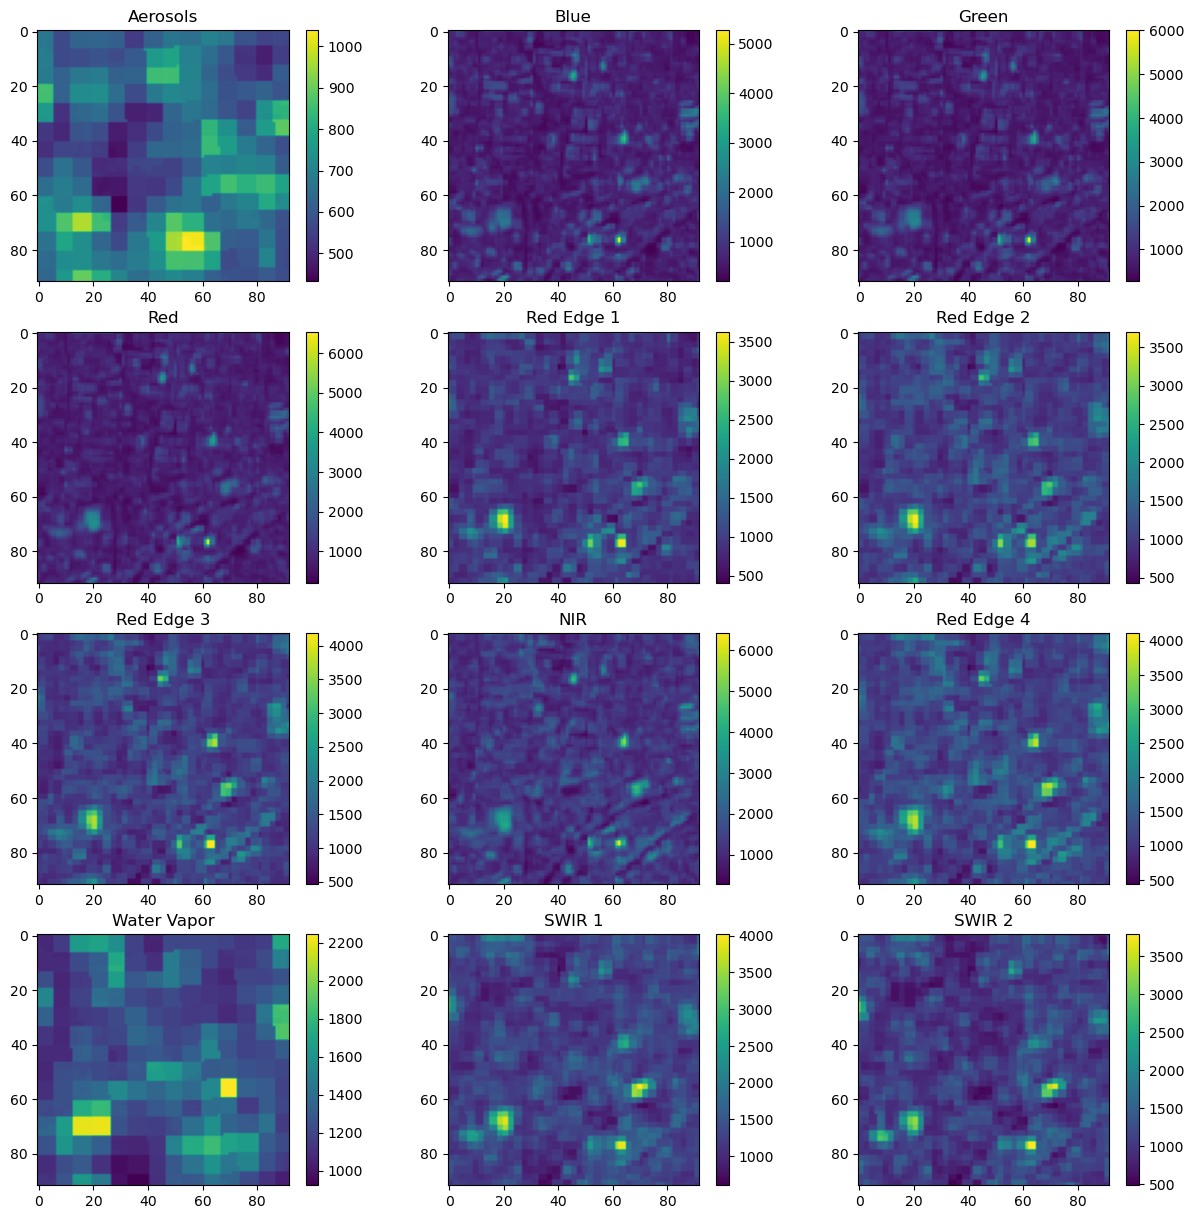

(12, 92, 92)

In [52]:
# Visualise
band_count = 0

bands_dict = {'B1':"Aerosols", 'B2':"Blue", 'B3':"Green", 'B4':"Red", 'B5':"Red Edge 1", 'B6':"Red Edge 2", 'B7':"Red Edge 3", 
                'B8':"NIR", 'B8A':"Red Edge 4", 'B9':"Water Vapor", 'B11':"SWIR 1", 'B12':"SWIR 2"}

fig, axs = plt.subplots(4, 3, figsize= (15, 15))

for col in range(4):
    for row in range(3):
        f = plt.subplot(4, 3, band_count+1)
        f_img = plt.imshow(img_array_cropped[band_count, :, :])
        plt.title(bands_dict[bands_lst[band_count]])
        band_count += 1
        fig.colorbar(f_img, ax= axs[col, row])
    

plt.show()

img_array_cropped.shape

In [53]:
# RGB Image Visualisation
band1 = sentinel_3857.GetRasterBand(1)
band2 = sentinel_3857.GetRasterBand(2)
band3 = sentinel_3857.GetRasterBand(3)


In [54]:
b1 = band1.ReadAsArray()
b2 = band2.ReadAsArray()
b3 = band3.ReadAsArray()

In [55]:
b1.shape

(226, 224)

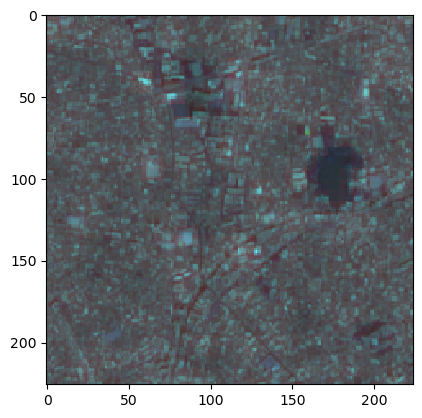

(226, 224, 3)

In [57]:
img = np.dstack((b1, b2, b3))
img *= (255.0/img.max())
f = plt.figure()
img = np.array(img, dtype= "uint8")
img = adjust_gamma(img, 2)
plt.imshow(img, interpolation= "nearest")
# plt.savefig('Tiff.png')
plt.show()
img.shape

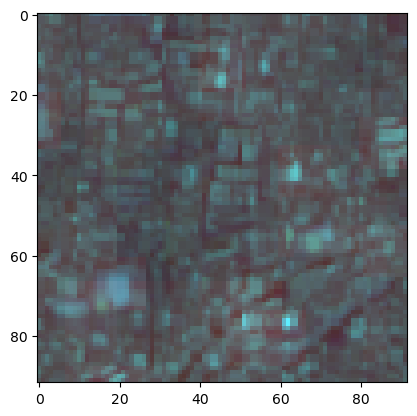

In [58]:
# We can see how reprojecting the image changes the orientation a little
img = np.dstack((b1, b2, b3))
img *= (255.0/img.max())
f = plt.figure()
img = np.array(img, dtype= "uint8")
img = adjust_gamma(img, 2)
plt.imshow(img[center_pt[0]-pixel_buffer:center_pt[0]+pixel_buffer, center_pt[1]-pixel_buffer:center_pt[1]+pixel_buffer, :], interpolation= "nearest")
# plt.imshow(img[500:601, 500:601, :], interpolation= "nearest")

# plt.savefig('Tiff.png')
plt.show()

In [59]:
getBounds(sentinel_3857)

Upper Left Corner: 15548350.0 4247056.526830854
Lower Right Corner: 15550810.361149484 4244574.198171106
Width: 2460.3611494842917
Height: 2482.328659747727
Area: 6107424.994694719


(15548350.0, 4244574.198171106, 15550810.361149484, 4247056.526830854)

In [206]:
# Clear memory
del data
# del sentinel_3857
del img
del img_array

# Plateau Dataset

Since we have a copy already, skip from here

In [60]:
# Read the original shape file
# Note that for actual use we would have to do the compiling of the different areas ourselves
# It takes a significant amount of time to reproject the shape file, so perhaps it would be better to either merge and load it at one go,
# Or load the individual pieces as per needed

# plateau_3857 = geopandas.read_file("data/full_Tokyo_plateau/full_Tokyo_plateau.shp")

# Convert the geopandas file to EPSG:3857 projection (metric)
# plateau_3857 = plateau_3857.to_crs('EPSG:3857')

In [61]:
# plateau_3857.dtypes

height        float64
filestart      object
geometry     geometry
dtype: object

In [62]:
# Check for Nan Values
# plateau_3857[plateau_3857["height"].isna()]

,height,filestart,geometry
10437,NaN,53392559,"POLYGON Z ((15555612.806 4238580.074 2.196, 15..."
12221,NaN,53392566,"POLYGON Z ((15552473.729 4239971.703 3.748, 15..."
98334,NaN,53392650,"POLYGON Z ((15557039.673 4238754.864 1.254, 15..."
98361,NaN,53392650,"POLYGON Z ((15557025.575 4238299.834 1.619, 15..."
98364,NaN,53392650,"POLYGON Z ((15557031.209 4238301.282 1.981, 15..."
...,...,...,...
1454961,NaN,53395515,"POLYGON Z ((15550653.076 4267747.211 28.875, 1..."
1551359,NaN,53395543,"POLYGON Z ((15548027.229 4271810.692 3.675, 15..."
1646592,NaN,53395625,"POLYGON Z ((15564360.821 4268835.575 -0.323, 1..."
1664713,NaN,53395631,"POLYGON Z ((15559633.123 4270563.803 2.749, 15..."


In [63]:
# Remove Nan values
# plateau_3857 = plateau_3857.dropna().reset_index(drop= True)

# Check for Nan Values
# plateau_3857[plateau_3857["height"].isna()]

,height,filestart,geometry


In [64]:
# Save to file
# plateau_3857_path = "data/full_Tokyo_plateau/plateau_3857.shp"
# plateau_3857.to_file(plateau_3857_path)

In [42]:
# SKIP THIS #
# Rasterises the shape file to a geotiff file
# Sizes
# 1m = 6.1GB
# 0.5m = 24.6GB
# 0.25m = 95.6GB
# Due to very large file sizes, the shape file is first cropped then saved

# target_res = str(0.25) # In georeferenced unit (m)
# shp_path = plateau_3857_path
# suffix = target_res.replace(".", "_")
# dest_path = f"data/full_Tokyo_plateau/plateau_3857_{suffix}m.tiff"
# attribute = "height"
# no_data_val = str(0) #Assign a specified nodata value to output bands.
# output_type = "Float32" 
# override_proj = "EPSG:3857" 
# # Override the projection for the output file. If not specified, the projection of the input vector file will be used if available. 
# # When using this option, no reprojection of features from the SRS of the input vector to the specified SRS of the output raster, so use only this option to correct an invalid source SRS. 
# # The <srs_def> may be any of the usual GDAL/OGR forms, complete WKT, PROJ.4, EPSG:n or a file containing the WKT.

# subprocess.run([
#     "gdal_rasterize", 
#     "-a", attribute, 
#     "-a_nodata", no_data_val, 
#     "-ot", output_type, 
#     "-tr", target_res, target_res, 
#     shp_path, 
#     dest_path, 
#     "-a_srs", "EPSG:3857"])

In [17]:
# # Straight up flatten it from 3D to 2D cause we don't need the extra dimension
# plateau_3857_geometry = geopandas.GeoSeries.from_wkb(plateau_3857.to_wkb(output_dimension= 2)["geometry"])
# plateau_3857_temp = plateau_3857.drop(["geometry"], axis= 1)
# plateau_3857_temp = geopandas.GeoDataFrame(plateau_3857_temp, geometry= plateau_3857_geometry)
# # plateau_3857_temp = plateau_3857_temp.assign(geometry= plateau_3857_geometry)
# plateau_3857 = plateau_3857_temp
# plateau_3857

,height,filestart,geometry
0,8.3,53392546,"POLYGON ((15552702.883 4237726.505, 15552702.0..."
1,9.9,53392546,"POLYGON ((15552129.323 4237576.804, 15552124.0..."
2,7.8,53392546,"POLYGON ((15552056.691 4237693.318, 15552051.2..."
3,9.5,53392546,"POLYGON ((15552062.886 4237687.444, 15552058.6..."
4,6.5,53392546,"POLYGON ((15552510.890 4237720.847, 15552511.9..."
...,...,...,...
1768289,45.5,53393566,"POLYGON ((15552188.009 4250413.659, 15552184.1..."
1768290,45.3,53393566,"POLYGON ((15552180.643 4250435.984, 15552178.3..."
1768291,19.2,53393566,"POLYGON ((15552447.390 4251081.221, 15552440.1..."
1768292,8.6,53393566,"POLYGON ((15552024.800 4250390.671, 15552022.5..."


In [18]:
# plateau_3857.to_file("data/full_Tokyo_plateau/plateau_3857_2D.shp")

In [66]:
# Clip the area (based on the sentinel data) we need THEN we rasterize it
# Load from the file we created before
plateau_3857_path = "data/full_Tokyo_plateau/plateau_3857.shp" # This is here to account for skipping reprojecting ^
plateau_3857 = geopandas.read_file(plateau_3857_path)
sentinel_3857 = gdal.Open(output_raster, gdal.GA_ReadOnly)
# Get the bounds of the sentinel image (which was ~2000x2000m around the CITY)
min_x, min_y, max_x, max_y = getBounds(sentinel_3857)

# Clip the plateau geopandas of the shape file
plateau_clipped = geopandas.clip(plateau_3857, [min_x, min_y, max_x, max_y])
plateau_clipped

Upper Left Corner: 15548350.0 4247056.526830854
Lower Right Corner: 15550810.361149484 4244574.198171106
Width: 2460.3611494842917
Height: 2482.328659747727
Area: 6107424.994694719


,height,filestart,geometry
173104,12.1,53393514,"POLYGON Z ((15549280.377 4244596.111 28.840, 1..."
173485,10.0,53393514,"POLYGON Z ((15549238.691 4244623.329 28.361, 1..."
174612,9.5,53393514,"POLYGON Z ((15549267.423 4244632.258 28.019, 1..."
172464,15.5,53393514,"POLYGON ((15549220.695 4244574.198, 15549224.0..."
172171,10.6,53393514,"POLYGON Z ((15549193.224 4244592.237 24.276, 1..."
...,...,...,...
244764,9.8,53393534,"POLYGON ((15549737.223 4247056.527, 15549754.1..."
244964,12.0,53393534,"POLYGON Z ((15549682.579 4247044.722 36.957, 1..."
246281,17.2,53393534,"POLYGON Z ((15549658.350 4247051.776 36.813, 1..."
248154,9.4,53393534,"POLYGON Z ((15549659.311 4247050.167 37.082, 1..."


We can see that each polygon is 3D instead of 2D and that causes issues when rasterising

In [67]:
# No null values check
plateau_clipped[plateau_clipped.isna().any(axis=1)]

,height,filestart,geometry


In [68]:
# Straight up flatten it from 3D to 2D cause we don't need the extra dimension
plateau_clipped_geometry = geopandas.GeoSeries.from_wkb(plateau_clipped.to_wkb(output_dimension= 2)["geometry"])
plateau_clipped_temp = plateau_clipped.drop(["geometry"], axis= 1)
plateau_clipped_temp = geopandas.GeoDataFrame(plateau_clipped_temp, geometry= plateau_clipped_geometry)
# plateau_clipped_temp = plateau_clipped_temp.assign(geometry= plateau_clipped_geometry)
plateau_clipped = plateau_clipped_temp
plateau_clipped

,height,filestart,geometry
173104,12.1,53393514,"POLYGON ((15549280.377 4244596.111, 15549276.5..."
173485,10.0,53393514,"POLYGON ((15549238.691 4244623.329, 15549238.3..."
174612,9.5,53393514,"POLYGON ((15549267.423 4244632.258, 15549267.7..."
172464,15.5,53393514,"POLYGON ((15549220.695 4244574.198, 15549224.0..."
172171,10.6,53393514,"POLYGON ((15549193.224 4244592.237, 15549189.9..."
...,...,...,...
244764,9.8,53393534,"POLYGON ((15549737.223 4247056.527, 15549754.1..."
244964,12.0,53393534,"POLYGON ((15549682.579 4247044.722, 15549681.1..."
246281,17.2,53393534,"POLYGON ((15549658.350 4247051.776, 15549657.7..."
248154,9.4,53393534,"POLYGON ((15549659.311 4247050.167, 15549659.9..."


In [69]:
type(plateau_clipped)

geopandas.geodataframe.GeoDataFrame

In [70]:
type(plateau_clipped["geometry"])

geopandas.geoseries.GeoSeries

In [71]:
plateau_clipped.dtypes

height        float64
filestart      object
geometry     geometry
dtype: object

In [72]:
# Save it to file and name it appropriately
plateau_clipped_output = f"plateau_{int(min_x)}_{int(min_y)}_{int(max_x)}_{int(max_y)}.shp"

if not os.path.exists(f"./data/plateau_cropped/{int(min_x)}_{int(min_y)}_{int(max_x)}_{int(max_y)}"):
    os.makedirs(f"./data/plateau_cropped/{int(min_x)}_{int(min_y)}_{int(max_x)}_{int(max_y)}")
plateau_clipped.to_file(f"./data/plateau_cropped/{int(min_x)}_{int(min_y)}_{int(max_x)}_{int(max_y)}/{plateau_clipped_output}")

In [73]:
# Rasterises the shape file to a geotiff file
# Area: 

target_res = str(0.1) # In georeferenced unit (m)
shp_path = f"./data/plateau_cropped/{int(min_x)}_{int(min_y)}_{int(max_x)}_{int(max_y)}/{plateau_clipped_output}"
suffix = target_res.replace(".", "_")
dest_path = f"{os.path.splitext(shp_path)[0]}_{suffix}m.tiff"
attribute = "height"
no_data_val = str(0) #Assign a specified nodata value to output bands.
output_type = "Float32" 
override_proj = "EPSG:3857" 
# Override the projection for the output file. If not specified, the projection of the input vector file will be used if available. 
# When using this option, no reprojection of features from the SRS of the input vector to the specified SRS of the output raster, so use only this option to correct an invalid source SRS. 
# The <srs_def> may be any of the usual GDAL/OGR forms, complete WKT, PROJ.4, EPSG:n or a file containing the WKT.

subprocess.run([
    "gdal_rasterize", 
    "-a", attribute, 
    "-a_nodata", no_data_val, 
    "-ot", output_type, 
    "-tr", target_res, target_res, 
    shp_path, 
    dest_path, 
    "-a_srs", "EPSG:3857"])

0...10...20...30...40...50...60...70...80...90...100 - done.


CompletedProcess(args=['gdal_rasterize', '-a', 'height', '-a_nodata', '0', '-ot', 'Float32', '-tr', '0.1', '0.1', './data/plateau_cropped/15548350_4244574_15550810_4247056/plateau_15548350_4244574_15550810_4247056.shp', './data/plateau_cropped/15548350_4244574_15550810_4247056/plateau_15548350_4244574_15550810_4247056_0_1m.tiff', '-a_srs', 'EPSG:3857'], returncode=0)

In [55]:
# Clear memory
# del plateau_3857
# del plateau_clipped
# del plateau_clipped_temp
# del plateau_clipped_geometry

In [74]:
plateau_3857_data = gdal.Open(dest_path, gdal.GA_ReadOnly)
plateau_3857_array = plateau_3857_data.ReadAsArray()
plateau_3857_array.shape

(24824, 24605)

### Resume here

In [75]:
# plateau_3857_data = gdal.Open("data/plateau_cropped/15543343_4239548_15555805_4252071/plateau_15543343_4239548_15555805_4252071_0_25m.tiff", gdal.GA_ReadOnly)
plateau_3857_array = plateau_3857_data.ReadAsArray()
plateau_3857_array.shape

(24824, 24605)

Given high enough resolution, we cannot read the entire tif at once, hence, we should only crop out the area we need from the shape file, then rasterise the portion we need

In [76]:
# Each pixel is 0.1m
plateau_3857_data.GetGeoTransform()

(15548349.95, 0.1, 0.0, 4247056.576830854, 0.0, -0.1)

## Visualisaing the data, no processing
This is just to ensure that the functions and data are good

In [80]:
# Arbitrarily crop a 1 km^2
plateau_3857_array_cropped = plateau_3857_array[:10000, :10000] 

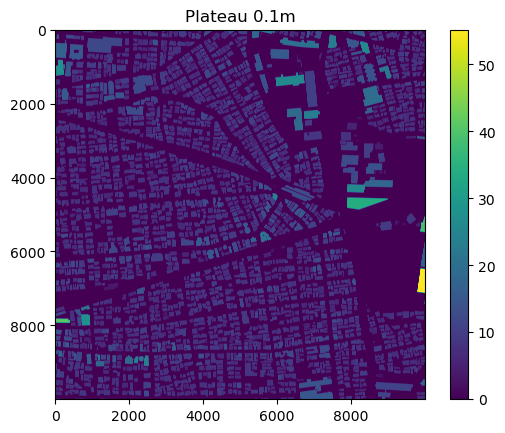

In [81]:
# Visualise
target_res = 0.1
f_img = plt.imshow(plateau_3857_array_cropped) # This needs to be done to not crash the kernel
plt.title(f"Plateau {target_res}m")
fig.colorbar(f_img)

### Calculate the Urban Morphological Parameters

In [83]:
# Since 0 values are ignored, set them to nan
plateau_3857_array_cropped_nan = plateau_3857_array_cropped.copy()
plateau_3857_array_cropped_nan[plateau_3857_array_cropped_nan == 0] = np.nan

Average Height: 9.777189254760742 m
Average Height (with 0s): 3.776792287826538 m
Maximum Height: 55.20000076293945 m
Maximum Height (with 0s): 55.20000076293945 m
Minimum Height: 2.0 m
Minimum Height (with 0s): 0.0 m
Standard Deviation: 4.959056854248047 m
Standard Deviation (with 0s): 5.671154022216797 m


(array([  292496.,  1250522., 18107454., 10561681.,  3328367.,  1674819.,
         1026123.,   635492.,   412060.,   226998.,   192882.,   350217.,
          153911.,        0.,        0.,   228685.,        0.,    35317.,
           43442.,        0.,        0.,        0.,        0.,        0.,
          108145.]),
 array([ 2.        ,  4.12800026,  6.25600004,  8.38399982, 10.51200008,
        12.64000034, 14.7680006 , 16.89599991, 19.02400017, 21.15200043,
        23.28000069, 25.40800095, 27.53600121, 29.66399956, 31.79199982,
        33.92000198, 36.04800034, 38.17599869, 40.30400085, 42.43199921,
        44.56000137, 46.68799973, 48.81600189, 50.94400024, 53.07200241,
        55.20000076]),
 <BarContainer object of 25 artists>)

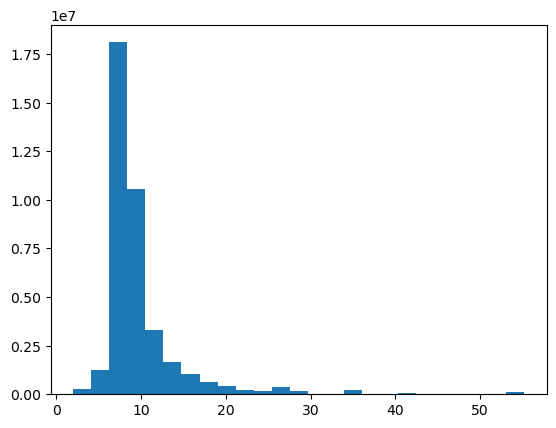

In [84]:
# Find height distribution

# Average Height
print(f"Average Height: {np.nanmean(plateau_3857_array_cropped_nan)} m")
print(f"Average Height (with 0s): {np.mean(plateau_3857_array_cropped)} m")

# Maximum Height
print(f"Maximum Height: {np.nanmax(plateau_3857_array_cropped_nan)} m")
print(f"Maximum Height (with 0s): {np.max(plateau_3857_array_cropped)} m")

# Minimum Height
print(f"Minimum Height: {np.nanmin(plateau_3857_array_cropped_nan)} m")
print(f"Minimum Height (with 0s): {np.min(plateau_3857_array_cropped)} m")

# Standard Deviation
print(f"Standard Deviation: {np.nanstd(plateau_3857_array_cropped_nan)} m")
print(f"Standard Deviation (with 0s): {np.std(plateau_3857_array_cropped)} m")

plt.hist(plateau_3857_array_cropped_nan.flatten(), bins= 25)

In [85]:
# Find total planar area
planar_area = np.sum(plateau_3857_array_cropped > 0) * target_res**2
total_area = plateau_3857_array_cropped.size * target_res**2
print(f"Planar Area: {planar_area} m^2")
print(f"Total Area: {total_area} m^2")

Planar Area: 386286.1100000001 m^2
Total Area: 1000000.0000000002 m^2


In [86]:
# Find total frontal area (Assume North/Top as front)
# Only non-zero pixels with a zero-pixel above it is considered in front facing area calculation
frontal_area = 0
for row in range(1, plateau_3857_array_cropped.shape[0]): # skips the first row as it is extremely unlikely that a building ends right there
    for col in range(plateau_3857_array_cropped.shape[1]):
        val = plateau_3857_array_cropped[row, col]
        if val > 0 and plateau_3857_array_cropped[row-1, col] == 0:
            frontal_area += val*target_res
        
print(f"Frontal Area: {frontal_area} m^2")

Frontal Area: 338146.7204295628 m^2


This takes too long, we will need to have a better algorithm for each/subsequent

Perhaps the next iteration can base it on this one then change accordingly

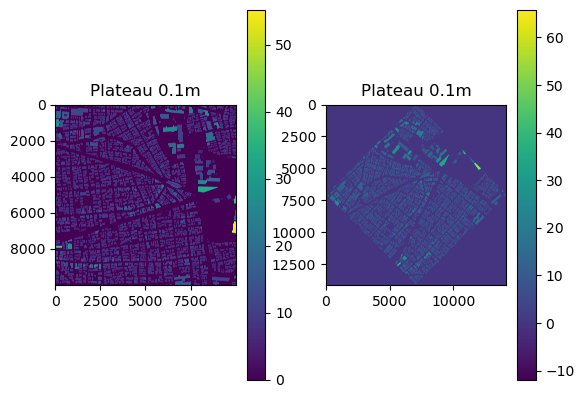

In [87]:
# Test to see if rotation works
plateau_3857_array_cropped_45 = rotate(plateau_3857_array_cropped, 45)
# Visualise
fig, ax = plt.subplots(1, 2)
plt.subplot(1, 2, 1) # This needs to be done to not crash the kernel
f = plt.imshow(plateau_3857_array_cropped)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)
plt.subplot(1, 2, 2) # This needs to be done to not crash the kernel
f = plt.imshow(plateau_3857_array_cropped_45)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)


In [93]:
test_arr = plateau_3857_array_cropped[:1000, :1000]
test_arr

array([[ 0. ,  0. ,  0. , ..., 10.6, 10.6, 10.6],
       [ 0. ,  0. ,  0. , ..., 10.6, 10.6, 10.6],
       [ 0. ,  0. ,  0. , ..., 10.6, 10.6, 10.6],
       ...,
       [ 0. , 27.9, 27.9, ..., 10. , 10. , 10. ],
       [ 0. , 27.9, 27.9, ..., 10. , 10. , 10. ],
       [ 0. , 27.9, 27.9, ..., 10. , 10. , 10. ]], dtype=float32)

In [98]:
len(np.where(plateau_3857_array_cropped == 0)[0])

61371389

In [117]:
print(*calcUMP(plateau_3857_array_cropped[:10000, :10000]).items(), sep= "\n")

Frontal Area 2: 84.1075177192688
Frontal Area 2.5: 50.881245374679565
('AverageHeight', 9.777189)
('MaximumHeight', 55.2)
('MinimumHeight', 2.0)
('PercentileHeight', 25.799999237060547)
('Percentile', 98)
('StandardDeviation', 4.959057)
('PlanarArea', 386286.1100000001)
('TotalArea', 1000000.0000000002)
('FrontalArea', 0.0)


In [90]:
# Rotation is iffy
print(*calcUMP(plateau_3857_array_cropped_45).items(), sep= "\n")

KeyboardInterrupt: 

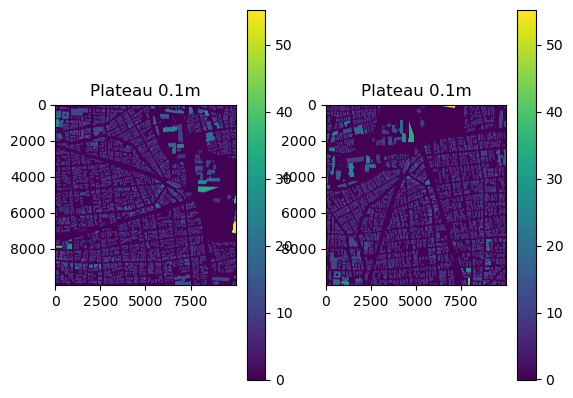

In [119]:
# Trying with 90 degrees instead
# Test to see if rotation works
plateau_3857_array_cropped_90 = rotate(plateau_3857_array_cropped, 90)
# Visualise
fig, ax = plt.subplots(1, 2)
plt.subplot(1, 2, 1) 
f = plt.imshow(plateau_3857_array_cropped)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)
plt.subplot(1, 2, 2) 
f = plt.imshow(plateau_3857_array_cropped_90)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)

In [ ]:
print("Default:")
print(*calcUMP(plateau_3857_array_cropped).items(), sep= "\n")
print()
# Still iffy
print("90 Degrees:")
print(*calcUMP(plateau_3857_array_cropped_90).items(), sep= "\n")

Default:
('AverageHeight', 15.233838)
('MaximumHeight', 27.9)
('MinimumHeight', 2.0)
('PercentileHeight', 27.899999618530273)
('Percentile', 98)
('StandardDeviation', 3.849874)
('PlanarArea', 23583.1875)
('TotalArea', 62500.0)
('FrontalArea', 7823.899848937988)

90 Degrees:
('AverageHeight', 8.046198)
('MaximumHeight', 27.9)
('MinimumHeight', -1.9841275e-15)
('PercentileHeight', 17.299999237060547)
('Percentile', 98)
('StandardDeviation', 8.103184)
('PlanarArea', 34463.5)
('TotalArea', 62500.0)
('FrontalArea', 1.7463682111648033e-42)


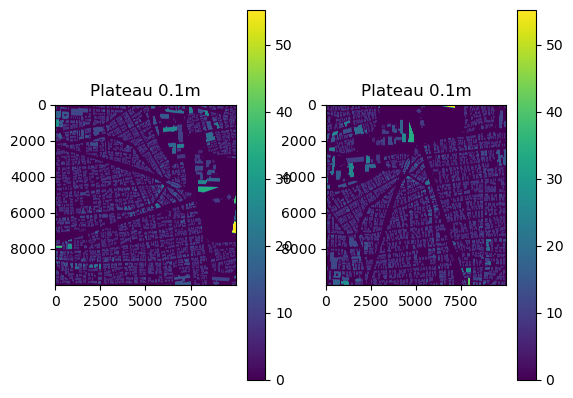

In [120]:
# Trying with np's 90 degrees instead
# Test to see if rotation works
plateau_3857_array_cropped_90_np = np.rot90(plateau_3857_array_cropped)
# Visualise
fig, ax = plt.subplots(1, 2)
plt.subplot(1, 2, 1) # This needs to be done to not crash the kernel
f = plt.imshow(plateau_3857_array_cropped)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)
plt.subplot(1, 2, 2) # This needs to be done to not crash the kernel
f = plt.imshow(plateau_3857_array_cropped_90_np)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)

In [121]:
print("Default:")
d0_UMP = calcUMP(plateau_3857_array_cropped)
print(*d0_UMP.items(), sep= "\n")
print()
# Consistent
print("90 Degrees:")
d90_UMP = calcUMP(plateau_3857_array_cropped_90_np)
print(*d90_UMP.items(), sep= "\n")

print(f"Frontal Area Deviation: {abs(d90_UMP['FrontalArea'] - d0_UMP['FrontalArea'])} m^2; {abs(d90_UMP['FrontalArea'] - d0_UMP['FrontalArea'])/min(d90_UMP['FrontalArea'] - d0_UMP['FrontalArea'])}")

Default:
('AverageHeight', 9.777189)
('MaximumHeight', 55.2)
('MinimumHeight', 2.0)
('PercentileHeight', 25.799999237060547)
('Percentile', 98)
('StandardDeviation', 4.959057)
('PlanarArea', 386286.1100000001)
('TotalArea', 1000000.0000000002)
('FrontalArea', 0.0)

90 Degrees:
('AverageHeight', 9.777218)
('MaximumHeight', 55.2)
('MinimumHeight', 2.0)
('PercentileHeight', 25.799999237060547)
('Percentile', 98)
('StandardDeviation', 4.959048)
('PlanarArea', 386286.1100000001)
('TotalArea', 1000000.0000000002)
('FrontalArea', 0.0)


TypeError: 'numpy.float64' object is not iterable

With increasing resolution of the rasterised building data, processing time to calculate the UMP is becoming increasingly inpractical

Hence we need a better way to calculate the UMPs, which is to use the original vector files

In [16]:
# Load from the cleaned/reprojected plateau shp we created before
plateau_3857_path = "data/full_Tokyo_plateau/plateau_3857.shp"
plateau_3857 = geopandas.read_file(plateau_3857_path)

# Dummy file for testing
sentinel_3857 = gdal.Open("data/sentinel/Sentinel_15549578_4245815_3857.tiff", gdal.GA_ReadOnly)
# Get the bounds of the sentinel image (which was ~2000x2000m around the CITY)
min_x, min_y, max_x, max_y = getBounds(sentinel_3857)
print(min_x, min_y, max_x, max_y)

# Clip the plateau geopandas of the shape file
plateau_clipped = geopandas.clip(plateau_3857, [min_x, min_y, max_x, max_y])
plateau_clipped

Upper Left Corner: 15548350.0 4247056.526830854
Lower Right Corner: 15550810.361149484 4244574.198171106
Width: 2460.3611494842917
Height: 2482.328659747727
Area: 6107424.994694719
Pixel Width: 10.98375513162716
15548350.0 4244574.198171106 15550810.361149484 4247056.526830854


,height,filestart,geometry
173104,12.1,53393514,"POLYGON Z ((15549280.377 4244596.111 28.840, 1..."
173485,10.0,53393514,"POLYGON Z ((15549238.691 4244623.329 28.361, 1..."
174612,9.5,53393514,"POLYGON Z ((15549267.423 4244632.258 28.019, 1..."
172464,15.5,53393514,"POLYGON ((15549220.695 4244574.198, 15549224.0..."
172171,10.6,53393514,"POLYGON Z ((15549193.224 4244592.237 24.276, 1..."
...,...,...,...
244764,9.8,53393534,"POLYGON ((15549737.223 4247056.527, 15549754.1..."
244964,12.0,53393534,"POLYGON Z ((15549682.579 4247044.722 36.957, 1..."
246281,17.2,53393534,"POLYGON Z ((15549658.350 4247051.776 36.813, 1..."
248154,9.4,53393534,"POLYGON Z ((15549659.311 4247050.167 37.082, 1..."


In [20]:
plateau_3857.dtypes

height        float64
filestart      object
geometry     geometry
dtype: object

In [22]:
test = plateau_3857.astype({"height": "float32"})
test.dtypes

height        float32
filestart      object
geometry     geometry
dtype: object

In [25]:
test.to_file("data/full_Tokyo_plateau/plateau_3857_2D_float32.shp")

# Interestingly enough the Float32 and 64 versions are of the same size

In [26]:
plateau_3857_2D = geopandas.read_file("data/full_Tokyo_plateau/plateau_3857_2D.shp")
plateau_3857_2D.head()
# Takes 46 seconds to load

,height,filestart,geometry
0,8.3,53392546,"POLYGON ((15552702.883 4237726.505, 15552702.0..."
1,9.9,53392546,"POLYGON ((15552129.323 4237576.804, 15552124.0..."
2,7.8,53392546,"POLYGON ((15552056.691 4237693.318, 15552051.2..."
3,9.5,53392546,"POLYGON ((15552062.886 4237687.444, 15552058.6..."
4,6.5,53392546,"POLYGON ((15552510.890 4237720.847, 15552511.9..."


In [56]:
test["geometry"].apply(lambda x: x.area)

0    61.220892
1    80.314969
2    97.271968
3    59.290400
4    73.991106
Name: geometry, dtype: float64

In [58]:
test["area"] = test["geometry"].apply(lambda x: x.area)

,height,filestart,geometry,area
0,8.3,53392546,"POLYGON ((15552702.883 4237726.505, 15552702.0...",61.220892
1,9.9,53392546,"POLYGON ((15552129.323 4237576.804, 15552124.0...",80.314969
2,7.8,53392546,"POLYGON ((15552056.691 4237693.318, 15552051.2...",97.271968
3,9.5,53392546,"POLYGON ((15552062.886 4237687.444, 15552058.6...",59.290400
4,6.5,53392546,"POLYGON ((15552510.890 4237720.847, 15552511.9...",73.991106


In [48]:
# How to iterate
for row in plateau_3857_2D.head().itertuples():
    print("Height:", row[1])
    print("Coordinates:", *row[3].exterior.coords)
    print("Area:", row[3].area)

Height: 8.3
Coordinates: (15552702.88263768, 4237726.504987534) (15552702.07679262, 4237722.878466052) (15552695.85067297, 4237724.276601498) (15552695.191406827, 4237721.260681365) (15552690.88103043, 4237722.217235681) (15552691.320555488, 4237724.215517653) (15552689.773255525, 4237724.546564143) (15552690.835644782, 4237729.209269157) (15552702.88263768, 4237726.504987534)
Area: 61.22089233374892
Height: 9.9
Coordinates: (15552129.322640214, 4237576.80393475) (15552124.06956493, 4237566.087222854) (15552117.620214997, 4237569.260465417) (15552121.624122012, 4237577.570921504) (15552123.614206927, 4237576.5931224525) (15552124.826469723, 4237579.054828547) (15552129.322640214, 4237576.80393475)
Area: 80.31496920087227
Height: 7.8
Coordinates: (15552056.691282248, 4237693.318158307) (15552051.213351004, 4237685.63460189) (15552042.845063657, 4237691.653972711) (15552048.32299204, 4237699.337537478) (15552056.691282248, 4237693.318158307)
Area: 97.27196762319075
Height: 9.5
Coordinate

In [75]:
test.apply(lambda x: x["height"] * x["area"], axis= 1)

0    508.133418
1    795.118164
2    758.721366
3    563.258803
4    480.942191
dtype: float64

In [99]:
for i in test.itertuples():
    print(dict(i))

TypeError: cannot convert dictionary update sequence element #0 to a sequence

In [93]:
test.explode()

/tmp/ipykernel_28972/2977224133.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  test.explode()


,,height,filestart,area,geometry
0,0,8.3,53392546,61.220892,"POLYGON ((15552702.883 4237726.505, 15552702.0..."
1,0,9.9,53392546,80.314969,"POLYGON ((15552129.323 4237576.804, 15552124.0..."
2,0,7.8,53392546,97.271968,"POLYGON ((15552056.691 4237693.318, 15552051.2..."
3,0,9.5,53392546,59.290400,"POLYGON ((15552062.886 4237687.444, 15552058.6..."
4,0,6.5,53392546,73.991106,"POLYGON ((15552510.890 4237720.847, 15552511.9..."


In [101]:
calculateUMP(plateau_3857_2D, min_x, min_y, max_x, max_y)

Frontal edge substracted: -1358.894693236798
('TotalArea', 6107424.994694719)
('PlanarArea', 2346206.9934116094)
('PlanarAreaIndex', 0.38415649728808254)
('MaximumHeight', 55.2)
('MinimumHeight', 2.0)
('AverageHeightBuilding', 8.488920165299156)
('AverageHeightArea', 10.7084966173314)
('AverageHeightTotalArea', 4.113738551735311)
('PercentileHeight', 15.707999999999991)
('Percentile', 98)
('StandardDeviation', 2.8490357466322154)
('FrontalArea', 2175530.076011204)
('FrontalAreaIndex', 0.35621069074135203)


{'TotalArea': 6107424.994694719,
 'PlanarArea': 2346206.9934116094,
 'PlanarAreaIndex': 0.38415649728808254,
 'MaximumHeight': 55.2,
 'MinimumHeight': 2.0,
 'AverageHeightBuilding': 8.488920165299156,
 'AverageHeightArea': 10.7084966173314,
 'AverageHeightTotalArea': 4.113738551735311,
 'PercentileHeight': 15.707999999999991,
 'Percentile': 98,
 'StandardDeviation': 2.8490357466322154,
 'FrontalArea': 2175530.076011204,
 'FrontalAreaIndex': 0.35621069074135203}

# Automate the creation of n samples

### Rough outline
1. Need to generate selection of points from which to get the areas of
2. For each point, get 1500*1500 m^2 around it from sentinel, download it
3. Reproject it and then crop it, and replace
4. Get the bounding area 
5. Load the tokyo shapefile, crop with the area, then calculate the UMP
6. Output UMP as label

### Naming System

The area of each input is set at 1km^2

sentinel: minx_miny

plateau: pandas with unique minx_miny, and UMP for each

### Generate the sequence of coordinates

1. Find the lowest point (min_y) of the polygon, then round to nearest int. This will be the starting point for the whole boundary polygon
2. Define the steps at which to take, which in this case is equal to the pixel width of sentinel (~12m)
3. Create a $1km^2$ boundary with the point as the LL (lower left)
4. Check if all four points are in the polygon
5. If LR point is not in polygon, move up one step, and go left until one step before LR is out of the polygon
6. If UL point is not in polygon, move right one step
7. If UR point is not in polygon, move up one step, and go left until one step before LR is out of the polygon
8. If all points in polygon, then save that as a boundary

Note that this will not work with complex shapes/shapes with concave components

In [10]:
# Load the minimum boundary shapefile
tokyo_boundary = gdal.ogr.Open("data/full_Tokyo_plateau/tokyo_boundary_eroded.shp")
polygon = tokyo_boundary.GetLayer(0)
#first feature of the shapefile
feature = polygon.GetFeature(0)
first = json.loads(feature.ExportToJson())
print(first) # (GeoJSON format)

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[15538130.257687405, 4267028.020441007], [15540008.107603025, 4268471.348187747], [15545316.340738075, 4270955.124933943], [15558984.784310175, 4273523.926590903], [15564450.1274322, 4273177.056644784], [15569205.471526233, 4270962.279778881], [15570719.582497936, 4269523.984034264], [15573521.421328139, 4259419.020005929], [15569926.124258282, 4253128.236324379], [15561169.699285183, 4238589.347275963], [15552570.506396942, 4239439.077834504], [15552310.135892872, 4239466.690806099], [15540836.998436583, 4249660.398250841], [15540418.258429935, 4251743.183039011], [15538352.386750072, 4262618.640049928], [15538130.257687405, 4267028.020441007]]]}, 'properties': {}, 'id': 0}


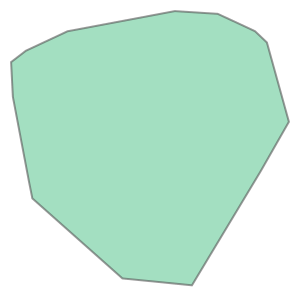

In [11]:
tokyo_boundary_shape = shape(first["geometry"])
tokyo_boundary_shape

In [12]:
# Find the lowest point (min y)

start_point = None
for point in tokyo_boundary_shape.exterior.coords:
    if start_point is None:
        start_point = point
    else:
        if point[1] < start_point[1]:
            start_point = point

print(f"The lowest point is:{start_point}")

The lowest point is:(15561169.699285183, 4238589.347275963)


In [14]:
# Create pandas dataframe to store the labels
# This dataframe stores the LL coordinate of a approx. 1km^2 area, hence the (x_coord, y_coord) will be the key to each entry
labels_df = pandas.DataFrame(columns= ["x_coord", "y_coord", 
                                    "height_avg", "height_std", "height_max", "height_98", 
                                    "planar_area", "frontal_area", "total_area",
                                    "planar_index", "frontal_index"])
labels_df

,x_coord,y_coord,height_avg,height_std,height_max,height_98,planar_area,frontal_area,total_area,planar_index,frontal_index


# Merge Sentinel and Plateau

In [122]:
file_list = [dest_path, output_raster]
print(file_list)

# Read metadata of first file
with rio.open(file_list[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rio.open("stack.tiff", 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

['./data/plateau_cropped/15548350_4244574_15550810_4247056/plateau_15548350_4244574_15550810_4247056_0_1m.tiff', './data/sentinel/Sentinel_15549578_4245815_3857.tiff']


In [132]:
# Merge issue, seems like bands not conserved, and file is very large
merged_data = gdal.Open("stack.tiff")
getBounds(merged_data)
merged_array = merged_data.ReadAsArray()

Upper Left Corner: 15548349.95 4247056.576830854
Lower Right Corner: 15550810.45 4244574.176830853
Width: 2460.5
Height: 2482.4000000003725
Area: 6107945.200000917
Pixel Width: 0.1


In [135]:
merged_array.shape

(2, 24824, 24605)

In [138]:
merged_array[1]

array([[804. , 804. , 804. , ..., 908.5, 908.5, 908.5],
       [804. , 804. , 804. , ..., 908.5, 908.5, 908.5],
       [804. , 804. , 804. , ..., 908.5, 908.5, 908.5],
       ...,
       [584.5, 584.5, 584.5, ..., 620. , 620. , 620. ],
       [584.5, 584.5, 584.5, ..., 620. , 620. , 620. ],
       [584.5, 584.5, 584.5, ..., 620. , 620. , 620. ]], dtype=float32)

In [133]:
# Just get the center 10000 pixels since the images are centered alr
# 10000 pixels = 1000m
merged_array_cropped = merged_array[merged_array.shape[0]//2 - 5000: merged_array.shape[0]//2 + 4999, 
                                    merged_array.shape[1]//2 - 5000: merged_array.shape[1]//2 + 4999]

In [134]:
merged_array_cropped.shape

(2, 9999, 24605)

In [123]:
# Obtain the bounds of each
sentinel_3857 = gdal.Open(output_raster, gdal.GA_ReadOnly)

print("Sentinel:")
getBounds(sentinel_3857)
# This will be the resultant file
corr_arr = sentinel_3857.ReadAsArray().copy()
print(corr_arr.shape)
print()
print("Plateau:")
getBounds(plateau_3857_data)
print(plateau_3857_array.shape)

Sentinel:
Upper Left Corner: 15548350.0 4247056.526830854
Lower Right Corner: 15550810.361149484 4244574.198171106
Width: 2460.3611494842917
Height: 2482.328659747727
Area: 6107424.994694719
(12, 226, 224)

Plateau:
Upper Left Corner: 15548349.95 4247056.576830854
Lower Right Corner: 15550810.45 4244574.176830853
Width: 2460.5
Height: 2482.4000000003725
Area: 6107945.200000917
(24824, 24605)


In [124]:
pixel_width = sentinel_3857.GetGeoTransform()[1]
print("Sentinel Pixel Width:", pixel_width)

Sentinel Pixel Width: 10.98375513162716


In [145]:
# Crop out each grid of the plateau dataset, calculate the parameters then add it into the grid
pixel_coords = getCoordinates(sentinel_3857, 0, 0)

(15543343.063898155, 4252071.729937454)

In [ ]:
rect = boundingRectangle(pixel_coords, pixel_width, pixel_width)
getPixel()

sample_grid = plateau_3857_array[]

# LandScan Dataset: Population

In [18]:
landscan_data = gdal.Open("data/landscan-global-2021-assets/landscan-global-2021-colorized.tif", gdal.GA_ReadOnly)
landscan_array = landscan_data.ReadAsArray()
landscan_array.shape

(4, 21600, 43200)

(4, 21600, 43200)

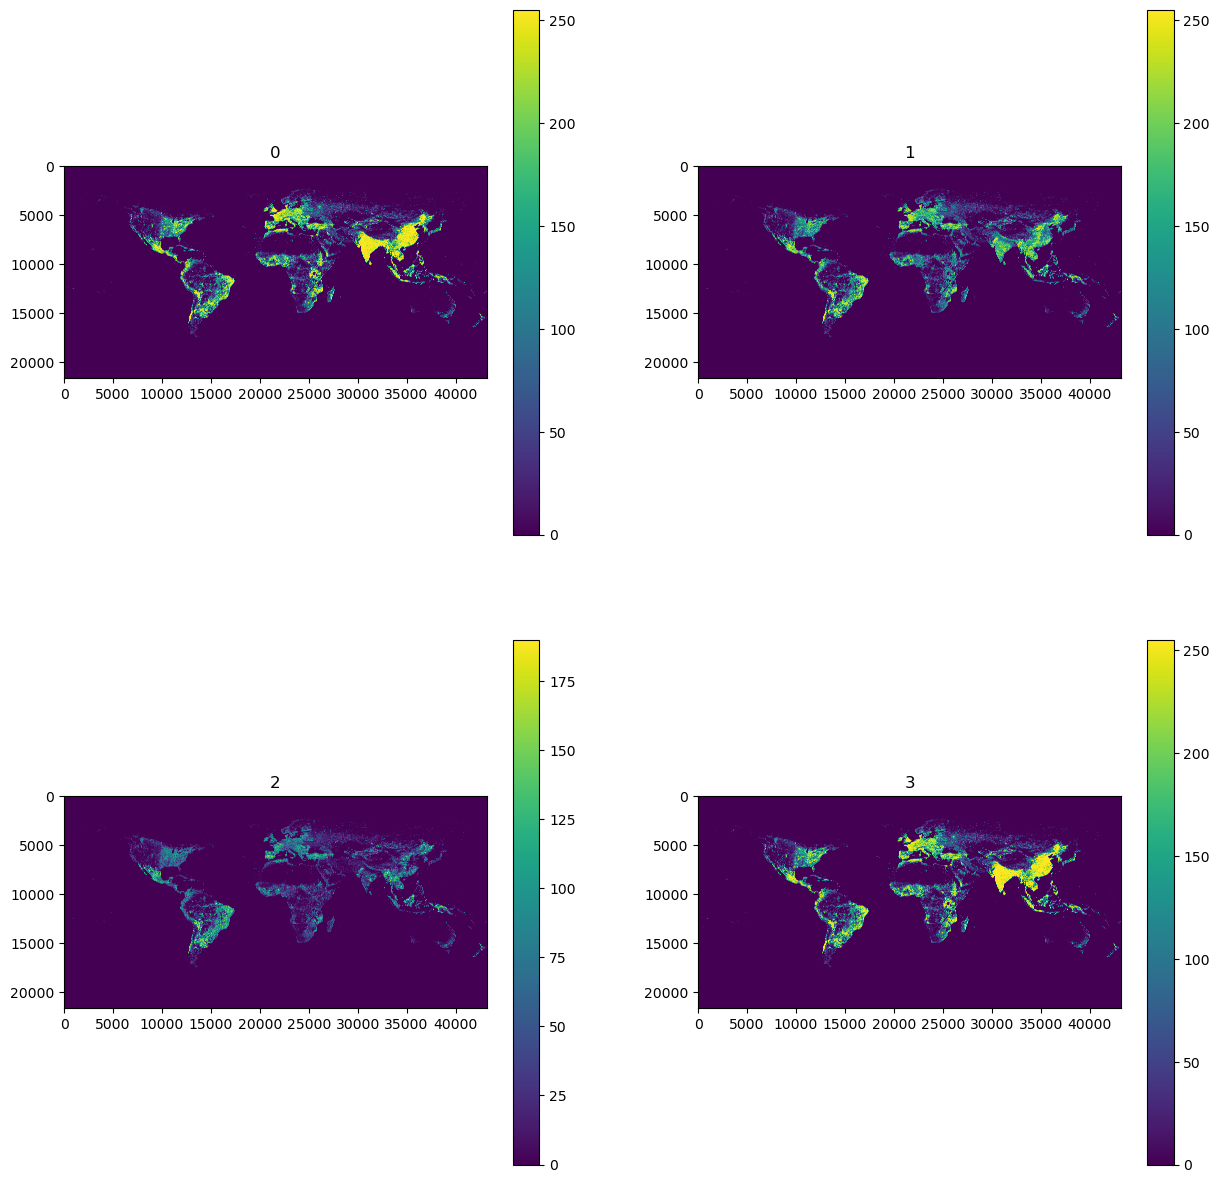

In [19]:
# Visualise
band_count = 0

fig, axs = plt.subplots(2, 2, figsize= (15, 15))

for col in range(2):
    for row in range(2):
        f = plt.subplot(2, 2, band_count+1)
        f_img = plt.imshow(landscan_array[band_count, :, :])
        plt.title(band_count)
        band_count += 1
        fig.colorbar(f_img, ax= axs[col, row])

In [20]:
landscan_single_data = gdal.Open("data/landscan-global-2021-assets/landscan-global-2021.tif", gdal.GA_ReadOnly)
landscan_single_array = landscan_single_data.ReadAsArray()
landscan_single_array.shape

(21600, 43200)

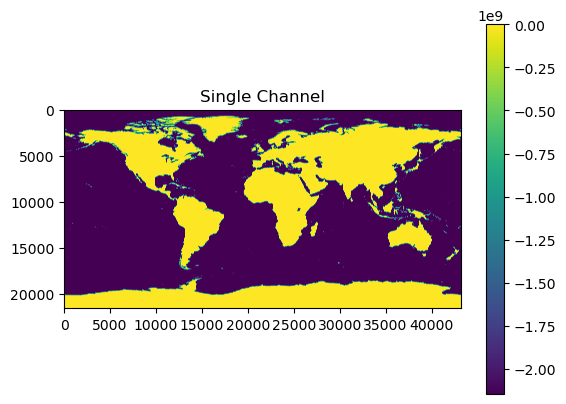

In [22]:
# Visualise
f_img = plt.imshow(landscan_single_array)
plt.title("Single Channel")
fig.colorbar(f_img)

In [24]:
# landscan_local = ee.Image("projects/ee-lqchan-1/assets/landscan-global-2021")
# Map.addLayer(landscan_local, {"min": 0, "max": 185000}, "landscan_local")

In [25]:
# Get the landscan data set and print out some details
# https://gee-community-catalog.org/projects/landscan/ 
landscan = ee.ImageCollection("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL")
landscan_bands_lst = landscan.first().bandNames().getInfo()
landscan_size = landscan.size().getInfo()
print(f"Landscan Bands: {landscan_bands_lst}")
print(f"Number of images in collection: {landscan_size}")

Landscan Bands: ['b1']
Number of images in collection: 22


In [26]:
print("### Image Properties ###")
print(sorted(landscan.first().propertyNames().getInfo()))

### Image Properties ###
['id_no', 'num_bands', 'system:asset_size', 'system:band_names', 'system:bands', 'system:footprint', 'system:id', 'system:index', 'system:time_end', 'system:time_start', 'system:version', 'xsize', 'ysize']


In [27]:
# Retrieve dates of image
print(*ds.getDates(landscan), sep= "\n")

2000/01/01 10:30
2001/01/01 10:30
2002/01/01 10:30
2003/01/01 10:30
2004/01/01 10:30
2005/01/01 10:30
2006/01/01 10:30
2007/01/01 10:30
2008/01/01 10:30
2009/01/01 10:30
2010/01/01 10:30
2011/01/01 10:30
2012/01/01 10:30
2013/01/01 10:30
2014/01/01 10:30
2015/01/01 10:30
2016/01/01 10:30
2017/01/01 10:30
2018/01/01 10:30
2019/01/01 10:30
2020/01/01 10:30
2021/01/01 10:30


In [43]:
# Display landscan_Image Metadata
# Display all metadata.
landscan_image = landscan.first()
# print('All metadata:', landscan_image)

# Get information about the bands as a list.
bandNames = landscan_image.bandNames().getInfo()
print('Band names:', bandNames)  # ee.List of band names

# Get projection information from band 1.
b1proj = landscan_image.select('b1').projection().getInfo()
print('Band 1 projection:', b1proj)  # ee.Projection object

# Get scale (in meters) information from band 1.
b1scale = landscan_image.select('b1').projection().nominalScale().getInfo()
print('Band 1 scale:', b1scale)  # ee.Number

# Get a list of all metadata properties.
properties = landscan_image.propertyNames().getInfo()
print('Metadata properties:', properties)  # ee.List of metadata properties

# Get version number (ingestion timestamp as microseconds since Unix epoch).
version = landscan_image.get('system:version').getInfo()
print('Version:', version)  # ee.Number
print('Version (as ingestion date):',
      ee.Date(ee.Number(version).divide(1000)).getInfo())  # ee.Date

# Get the timestamp and convert it to a date.
date = ee.Date(landscan_image.get('system:time_start')).getInfo()
print('Timestamp:', date)  # ee.Date

Band names: ['b1']
Band 1 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.0083333333333333, 0, -180, 0, -0.0083333333333333, 85.99999999999929]}
Band 1 scale: 927.662423277276
Metadata properties: ['system:time_start', 'num_bands', 'id_no', 'ysize', 'system:footprint', 'system:time_end', 'system:version', 'xsize', 'system:id', 'system:asset_size', 'system:index', 'system:bands', 'system:band_names']
Version: 1664042032746763
Version (as ingestion date): {'type': 'Date', 'value': 1664042032746}
Timestamp: {'type': 'Date', 'value': 946690200000}


In [44]:
landscan_image_min = landscan_image.select("b1").get("min").getInfo()
print(landscan_image_min)

None


In [45]:
# Get min and max values from band 1
minmax = landscan_image.select("b1").min(landscan_image).getInfo(), landscan_image.select("b1").max(landscan_image).getInfo()
print(f"Band 1 Range: {minmax}")

Band 1 Range: ({'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:4326', 'crs_transform': [0.0083333333333333, 0, -180, 0, -0.0083333333333333, 85.99999999999929]}]}, {'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:4326', 'crs_transform': [0.0083333333333333, 0, -180, 0, -0.0083333333333333, 85.99999999999929]}]})


In [30]:
Map

Map(center=[35.60069037543433, 139.6842362073651], controls=(WidgetControl(options=['position', 'transparent_b…

In [28]:
Map.addLayer(landscan.first(), {"min": 0, "max": 185000}, "landscan")

# Merging the Datasets

Currently, we are doing year 2021, as that is the latest image available from landscan dataset. One thing to note is that it is 2021/01/01, so perhaps it's better to treat it as 2020? 

In [29]:
# The median from S2HR 2021
s2HR_2021 = ds.filterCollection(s2HR, [2021], "Y_S")
s2HR_2021_cloudless = ds.remove_clouds(s2HR_2021)
s2HR_2021_median = s2HR_2021_cloudless.median()

In [30]:
# The landscan from 2021
landscan_2021 = ds.filterCollection(landscan, [2021], "Y_S")
print(ds.getDates(landscan_2021))
landscan_2021 = landscan_2021.first()
landscan_2021 = landscan_2021.toDouble()
landscan_2021.bandTypes().getInfo()

['2021/01/01 10:30']


{'b1': {'type': 'PixelType', 'precision': 'double'}}

In [31]:
ds.getInfo(s2HR_2021_median)

Band names: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
Band: B1
B1 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B1 scale: 111319.49079327357
Band: B2
B2 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B2 scale: 111319.49079327357
Band: B3
B3 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B3 scale: 111319.49079327357
Band: B4
B4 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B4 scale: 111319.49079327357
Band: B5
B5 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B5 scale: 111319.49079327357
Band: B6
B6 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B6 scale: 111319.49079327357
Band: B7
B7 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B7 scale: 111319.49079327357
Band: B8


In [32]:
ds.getInfo(landscan_2021)

Band names: ['b1']
Band: b1
b1 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.0083333333333333, 0, -180, 0, -0.0083333333333333, 89.99999999999929]}
b1 scale: 927.662423277276
Metadata properties: ['system:time_start', 'num_bands', 'id_no', 'ysize', 'system:footprint', 'system:time_end', 'system:version', 'xsize', 'system:id', 'system:asset_size', 'system:index', 'system:bands', 'system:band_names']
DateTime: 2021/01/01 10:30


In [33]:
# Combined Image Collection
combined_img = s2HR_2021_median.addBands(landscan_2021)
ds.getInfo(combined_img)


Band names: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'b1']
Band: B1
B1 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B1 scale: 111319.49079327357
Band: B2
B2 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B2 scale: 111319.49079327357
Band: B3
B3 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B3 scale: 111319.49079327357
Band: B4
B4 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B4 scale: 111319.49079327357
Band: B5
B5 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B5 scale: 111319.49079327357
Band: B6
B6 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B6 scale: 111319.49079327357
Band: B7
B7 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B7 scale: 111319.49079327357
Ban

In [68]:
# Get scale (in meters) information from band 1.
b1scale = s2HR.median().select("B2").projection().nominalScale().getInfo()
print(f'scale:', b1scale)  # ee.Number

scale: 111319.49079327357


What we want to do currently:
1. Combine the datasets into a single image
2. Have a fixed grid system (geometry bounds starting from a certain point, for now use landscan as reference)
3. For each bound, plot the RBG of the sentinel as well as return a value for the population

In [57]:
# # Filter Image by bounds
# combined_img_filtered = combined_img.clip(ds.boundingRectangle(CITY, 10000, 10000, "EPSG:4326"))

# # Cast all to float
# combined_img_filtered = combined_img_filtered.toFloat()



In [58]:
# Map.addLayer(combined_img_filtered)

In [34]:
ds.exportImageToDrive(combined_img, CITY, [1000, 1000], "Landscan", projection= combined_img.select("B2").projection().getInfo(), prefix= "LandScan")

<Task OMFG2DXZZGBZFWCIRVXFFFCC EXPORT_IMAGE: LandScan_UNKNOWN_DT (UNSUBMITTED)>

In [63]:
combined_img.bandTypes().getInfo()

{'B1': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B11': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B12': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B2': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B3': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B4': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B5': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B6': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B7': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B8': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B8A': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B9': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'b1': {'type': 'PixelType',
  'precision': 'int',
  'min': -2147483648,


In [ ]:
print('Multi-band GeoTIFF file',
  combined_img.getDownloadURL({
    "bands": ['B3', 'B8', 'B11'],
    "region": ds.boundingRectangle(CITY, 100, 100, combined_img.select("B2").projection().getInfo()),
    "scale": 10,
    format: 'GEO_TIFF'
  }))